In [ ]:
!pip install shap
!pip install catboost
!pip install lightgbm
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dill

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
#from catboost import CatBoostClassifier
#from lightgbm import LGBMClassifier
#from xgboost import XGBClassifier
from scipy.stats import chi2_contingency, mannwhitneyu, shapiro
from imblearn.combine import SMOTEENN
import tensorflow as tf
from tensorflow import keras
#import shap

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data description
Diabetes_binary : you have diabetes (0,1)

HighBP : Adults who have been told they have high blood pressure by a doctor, nurse, or other health professional (0,1)

HighChol : Have you EVER been told by a doctor, nurse or other health professional that your blood cholesterol is high? (0,1)

CholCheck : Cholesterol check within past five years (0,1)

BMI : Body Mass Index (BMI)

Smoker : Have you smoked at least 100 cigarettes in your entire life? [Note: 5 packs = 100 cigarettes] (0,1)

Stroke : (Ever told) you had a stroke. (0,1)

HeartDiseaseorAttack : Respondents that have ever reported having coronary heart disease (CHD) or myocardial infarction (MI) (0,1)

PhysActivity : Adults who reported doing physical activity or exercise during the past 30 days other than their regular job (0,1)

Fruits : Consume Fruit 1 or more times per day (0,1)

Veggies : Consume Vegetables 1 or more times per day (0,1)

HvyAlcoholConsump : Heavy drinkers (adult men having more than 14 drinks per week and adult women having more than 7 drinks per week)(0,1)

AnyHealthcare : Do you have any kind of health care coverage, including health insurance, prepaid plans such as HMOs, or government plans such as Medicare, or Indian Health Service? (0,1)

NoDocbcCost : Was there a time in the past 12 months when you needed to see a doctor but could not because of cost? (0,1)

GenHlth : Would you say that in general your health is: rate (1 ~ 5)

MentHlth : Now thinking about your mental health, which includes stress, depression, and problems with emotions, for how many days during the past 30 days was your mental health not good? (0 ~ 30)

PhysHlth : Now thinking about your physical health, which includes physical illness and injury, for how many days during the past 30 days was your physical health not good? (0 ~ 30)

DiffWalk : Do you have serious difficulty walking or climbing stairs? (0,1)

Sex : Indicate sex of respondent (0,1) (Female or Male)

Age : Fourteen-level age category (1 ~ 14)

Education : What is the highest grade or year of school you completed? (1 ~ 6)

Income : Is your annual household income from all sources: (If respondent refuses at any income level, code "Refused.") (1 ~ 8)

##EDA

In [8]:
df = pd.read_csv('/content/drive/MyDrive/business_ml/course_project/diabetes_binary_health_indicators_BRFSS2015.csv')

In [ ]:
df.head(3)

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_binary       253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [ ]:
# данные чистые, выбросов пока не видно, кроме BMI
df.describe()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,...,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.139333,0.429001,0.424121,0.962670,28.382364,0.443169,0.040571,0.094186,0.756544,0.634256,...,0.951053,0.084177,2.511392,3.184772,4.242081,0.168224,0.440342,8.032119,5.050434,6.053875
std,0.346294,0.494934,0.494210,0.189571,6.608694,0.496761,0.197294,0.292087,0.429169,0.481639,...,0.215759,0.277654,1.068477,7.412847,8.717951,0.374066,0.496429,3.054220,0.985774,2.071148
min,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,5.000000
50%,0.000000,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,7.000000
75%,0.000000,1.000000,1.000000,1.000000,31.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,10.000000,6.000000,8.000000
max,1.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000


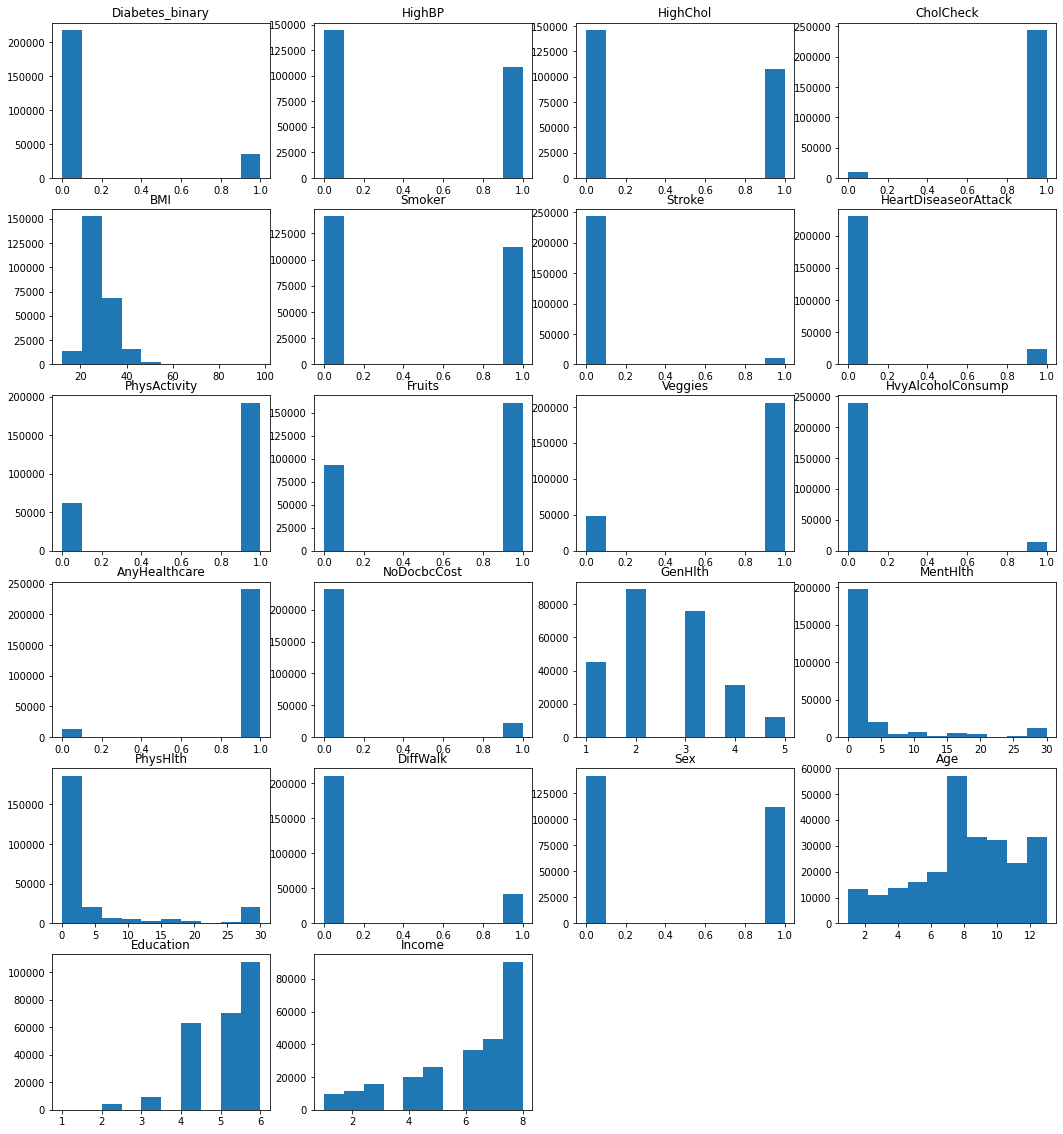

In [ ]:
plt.figure(figsize=(18, 20))
for ind, el in enumerate(df.columns):
  plt.subplot(6, 4, ind + 1)
  plt.hist(df[el])
  plt.title(el)

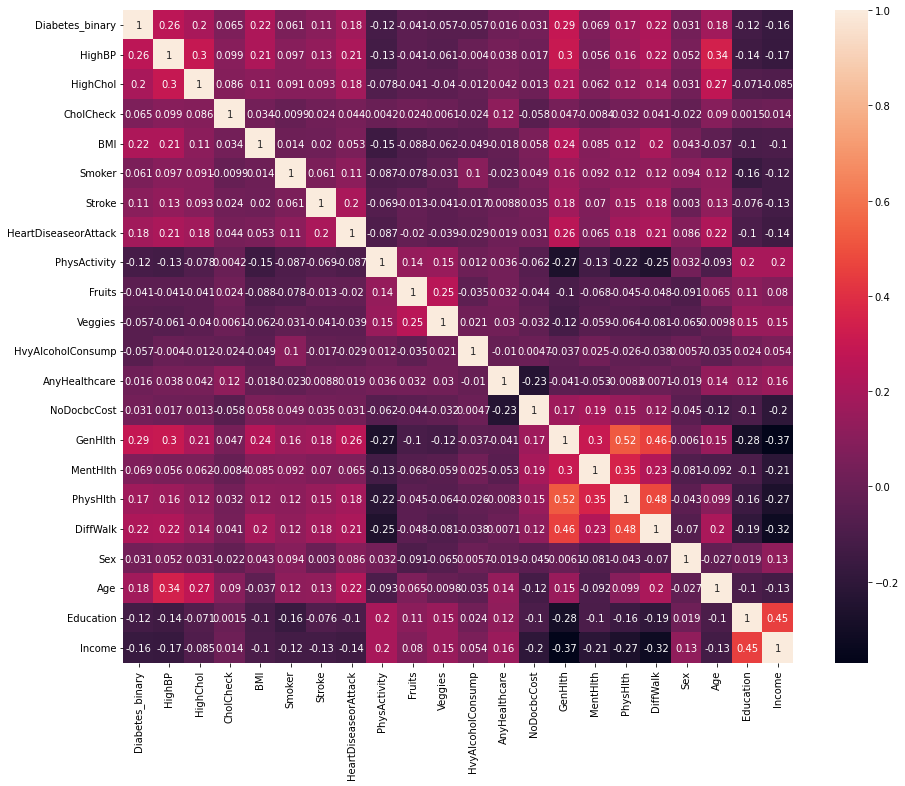

In [ ]:
plt.figure(figsize=(15,12))
corr = df.corr()
sns.heatmap(corr, annot=True)

In [ ]:
def show_crosstab(data1, data2, title, scale=False):
    crosstab = pd.crosstab(df[data1], df[data2])
    crosstab.plot(kind='bar', figsize=(10, 6))
    plt.title(title)
    plt.ylabel('Amount')
    plt.xticks(rotation=0)
    if scale:
        plt.yscale('log')


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


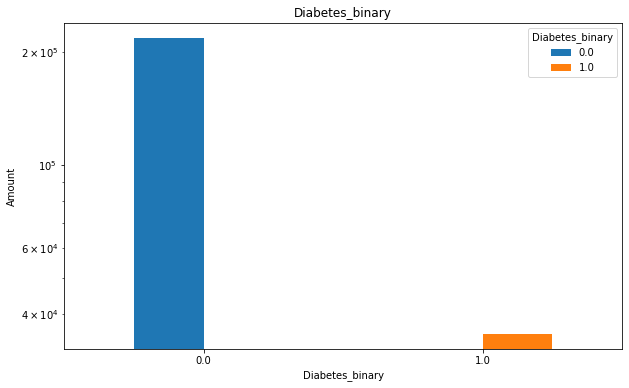

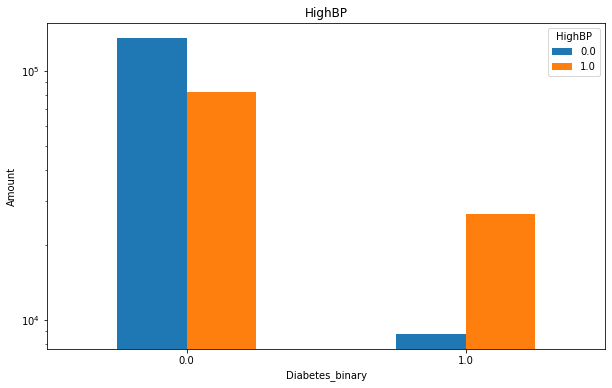

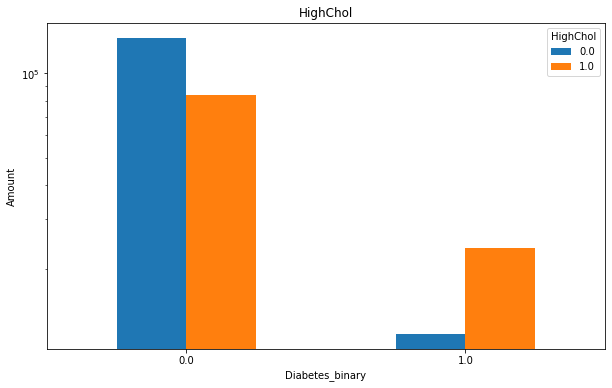

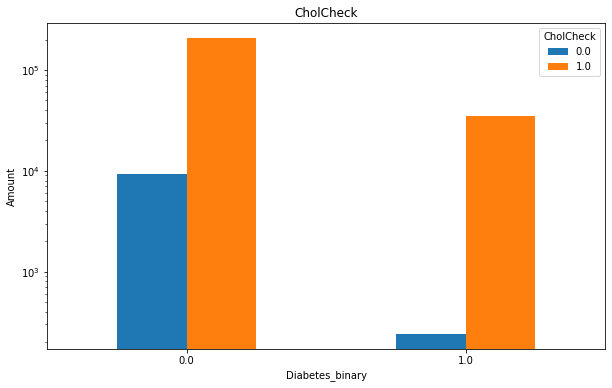

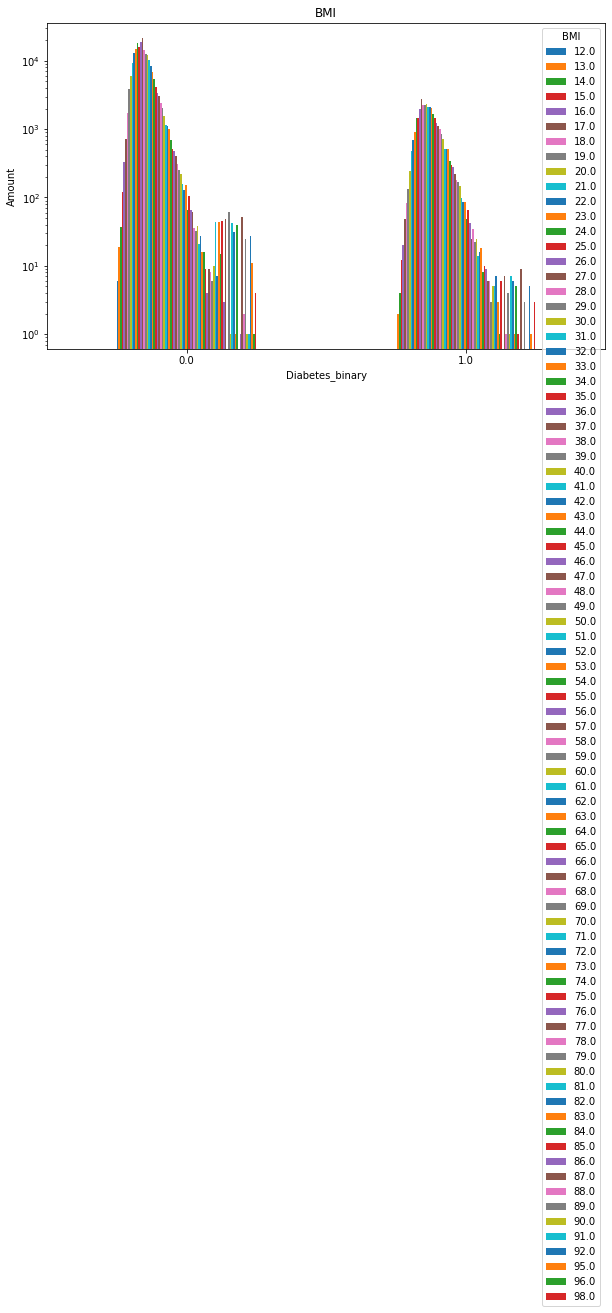

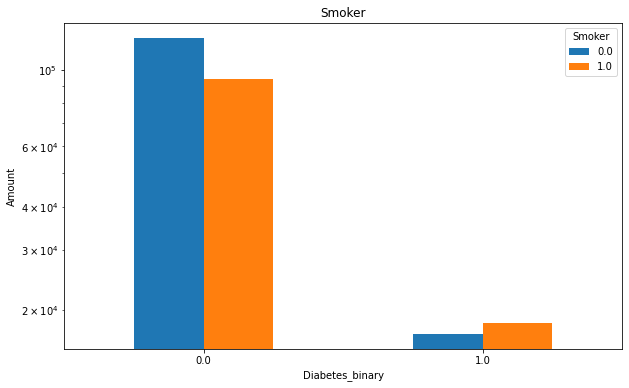

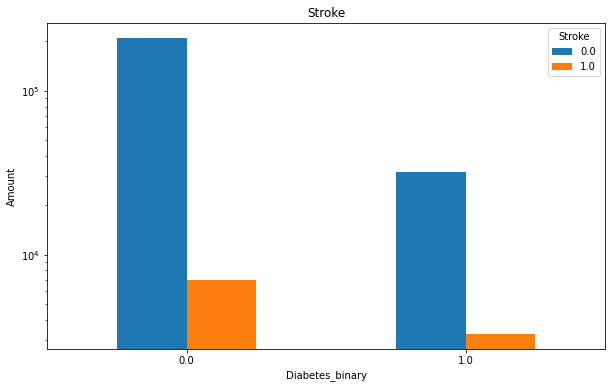

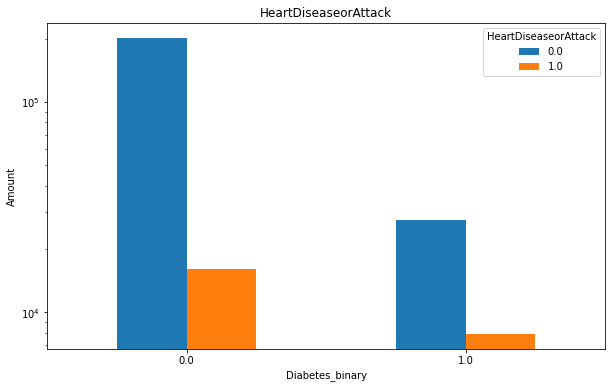

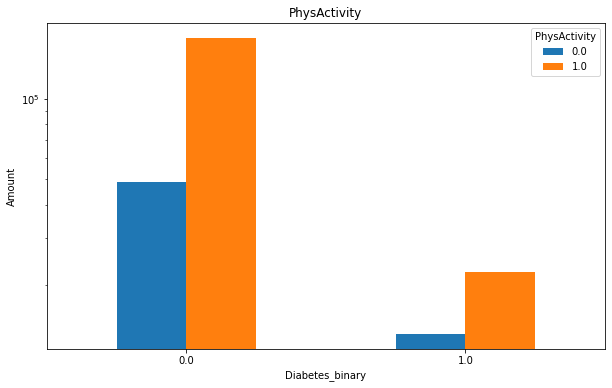

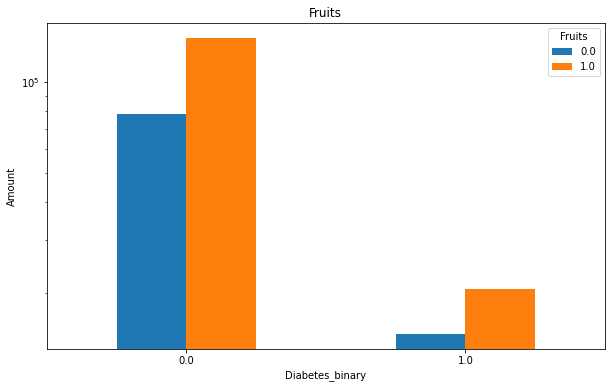

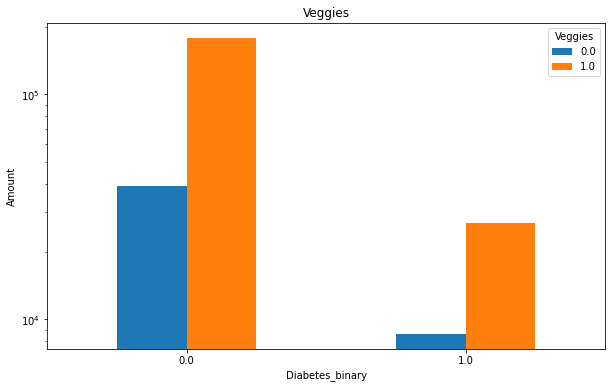

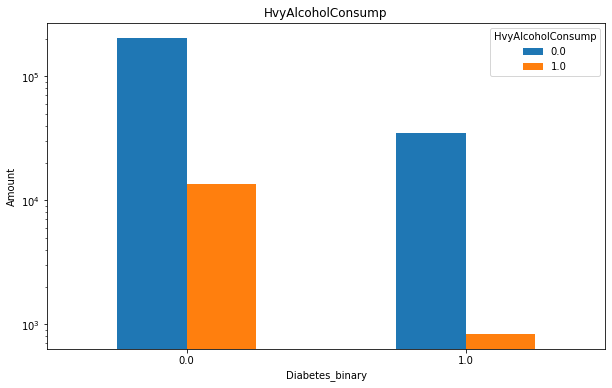

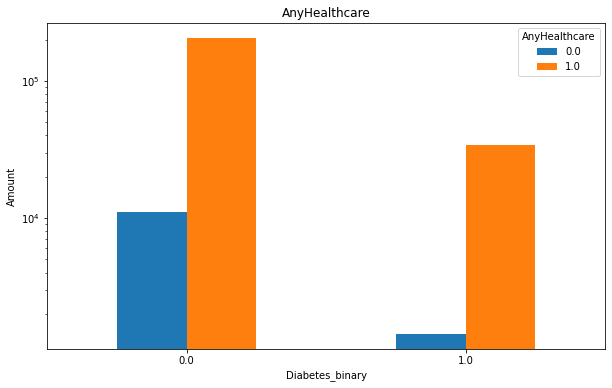

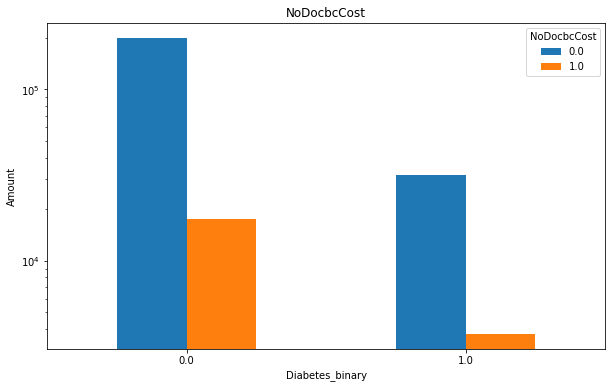

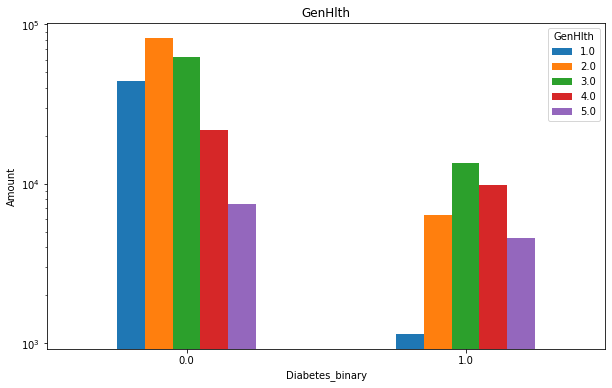

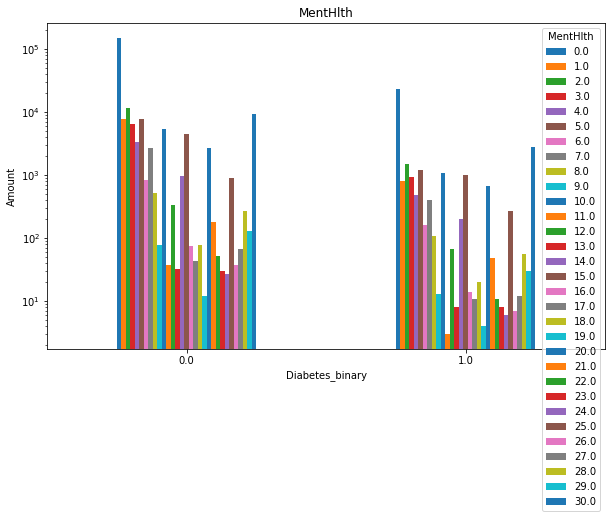

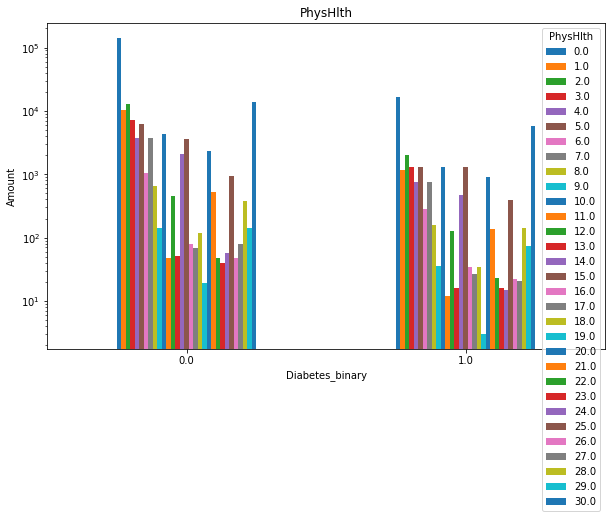

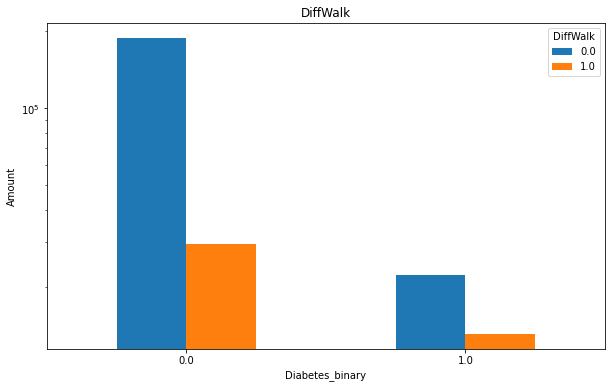

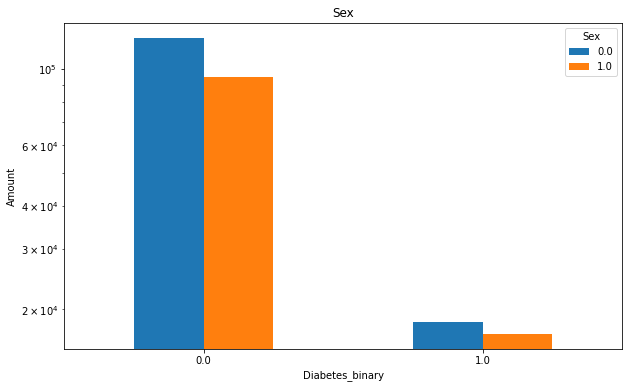

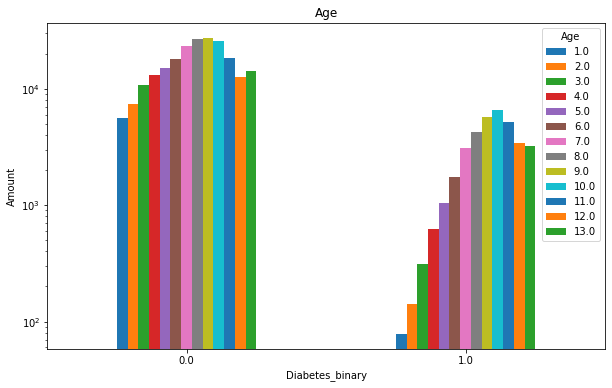

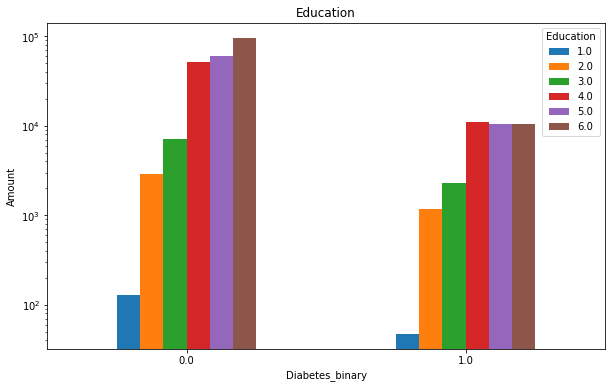

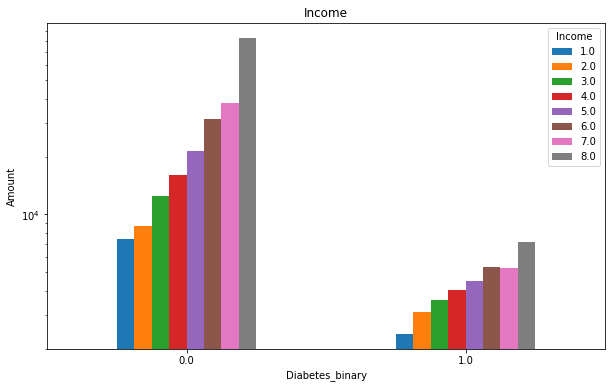

In [ ]:
# Проверить:
# BMI
# Stroke
# HeartDiseaseorAttack
# Veggies
# Genhlth без первыx двух полей
# MentHlth
# PhysHlth
# Diffwalk
# Sex
# Education
# income

for el in df.columns:
    show_crosstab('Diabetes_binary', el, el, scale=True)

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


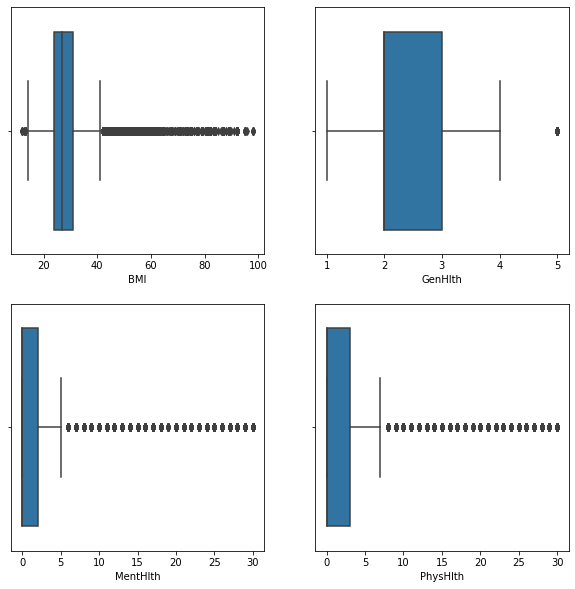

In [ ]:
# проверим на выбросы
# 'MentHlth', 'PhysHlth' имеют длинные "хвосты", и на графике в области 30 видны выбросы
# индекс массы тела больше 60 тоже выглядит подозрительно
plt.figure(figsize = (10,10))
for i,el in enumerate(['BMI', 'GenHlth', 'MentHlth', 'PhysHlth']):
    plt.subplot(2,2,i+1)
    sns.boxplot(df[el]);

## Check models

In [ ]:
X = df.drop('Diabetes_binary', axis=1)
y = df.Diabetes_binary

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.25,
                                                   random_state=42)

In [2]:
def metrics(y_true, y_preds, show=False):

    precision = precision_score(y_true, y_preds, zero_division=0)
    recall = recall_score(y_true, y_preds)
    f_score = f1_score(y_true, y_preds)
    accuracy = accuracy_score(y_true, y_preds)
    
    if show:
        return print('Precision=%.3f, Recall=%.3f, F_score=%.3f, Accuracy=%f' %(
        precision, recall, f_score, accuracy))
    else:
        return precision, recall, f_score, accuracy
    

In [9]:
def create_metrics(y_true, y_preds, b=1, show=False):
  precision, recall, thresholds = precision_recall_curve(y_true.values, y_preds)
  f_score = (1 + b ** 2) * (precision * recall) / (b ** 2 * precision + recall)
  f_score = np.nan_to_num(f_score, nan=0)
  ix = np.argmax(f_score)
  accuracy = accuracy_score(y_true, np.where(y_preds > thresholds[ix], 1, 0))

  if show:
    return print('Accuracy=%.3f, Precision=%.3f, Recall=%.3f, F-score=%.3f, Best_threshold=%f' % (
     accuracy, precision[ix], recall[ix], f_score[ix], thresholds[ix]   
    ))
  else:  
    return accuracy, precision[ix], recall[ix], f_score[ix], thresholds[ix]
  


In [ ]:
from xgboost import XGBClassifier
models_dict = {'Bagging': BaggingClassifier(),
               'RandomForest': RandomForestClassifier(),
              'Catboost': CatBoostClassifier(silent=True),
               'LGBM': LGBMClassifier(),
               'XGBoost': XGBClassifier(),
               'KNN': KNeighborsClassifier(),
              'Logreg': LogisticRegression(max_iter=1000)
              }
preds_dict = {}
preds_proba_dict = {}

for name, model in models_dict.items():        
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    proba = model.predict_proba(X_test)[:, 1]
    preds_dict[name] = preds
    preds_proba_dict[name] = proba      

In [ ]:
for name, preds in preds_dict.items():
    print(name)
    metrics(y_test, preds, show=True) 

Bagging
Precision=0.404, Recall=0.200, F_score=0.267, Accuracy=0.848770
RandomForest
Precision=0.481, Recall=0.172, F_score=0.253, Accuracy=0.859902
Catboost
Precision=0.563, Recall=0.171, F_score=0.263, Accuracy=0.867092
LGBM
Precision=0.576, Recall=0.159, F_score=0.249, Accuracy=0.867581
XGBoost
Precision=0.578, Recall=0.156, F_score=0.245, Accuracy=0.867629
KNN
Precision=0.398, Recall=0.194, F_score=0.260, Accuracy=0.848045
Logreg
Precision=0.540, Recall=0.160, F_score=0.247, Accuracy=0.865137


In [ ]:
for name, preds in preds_proba_dict.items():
    print(name)
    create_metrics(y_test, preds, show=True) 

Bagging
Accuracy=0.759, Precision=0.304, Recall=0.576, F-score=0.398, Best_threshold=0.293333
RandomForest
Accuracy=0.783, Precision=0.341, Recall=0.614, F-score=0.438, Best_threshold=0.230357
Catboost
Accuracy=0.802, Precision=0.373, Recall=0.635, F-score=0.470, Best_threshold=0.222834
LGBM
Accuracy=0.809, Precision=0.382, Recall=0.619, F-score=0.473, Best_threshold=0.235471
XGBoost
Accuracy=0.810, Precision=0.384, Recall=0.618, F-score=0.473, Best_threshold=0.230670
KNN
Accuracy=0.848, Precision=0.326, Recall=0.428, F-score=0.370, Best_threshold=0.400000
Logreg
Accuracy=0.800, Precision=0.367, Recall=0.619, F-score=0.460, Best_threshold=0.210798


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


## Важность признаков

In [ ]:
# используем shap
# XGBoost
model = models_dict['XGBoost']
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

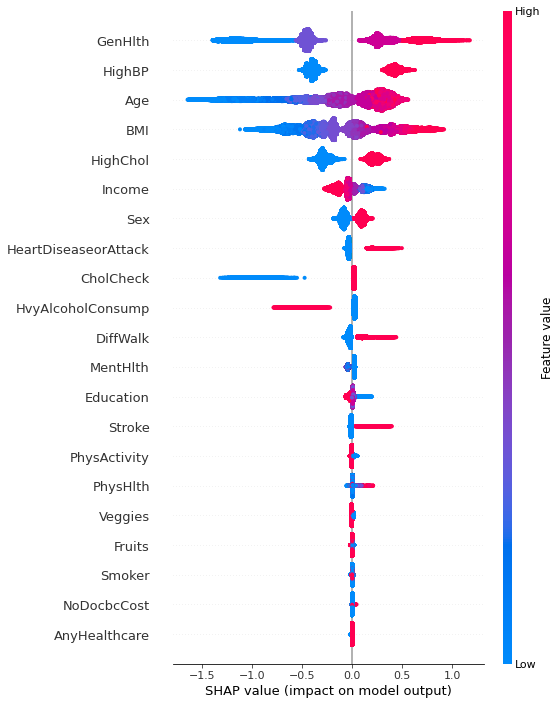

In [ ]:
shap.summary_plot(shap_values, X_train, max_display=X_train.shape[1])

In [ ]:
# сделаем OneHot кодирование и посмотрим на важность признаков отдельно
# напишем класс
class ColTrans:
    def __init__(self, data, key):
        self.data = data
        self.key = key
        
    def fit_transform_data(self):
        self.data = pd.get_dummies(self.data, columns=self.key)
        return pd.DataFrame(self.data)

In [ ]:
transformer = ColTrans(df, ['Age', 'Income', 'GenHlth' ,'MentHlth', 'PhysHlth', 'Education'])
new = transformer.fit_transform_data()
X = new.drop('Diabetes_binary', axis=1)
y = new.Diabetes_binary

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.25,
                                                   random_state=42)

In [ ]:
model = CatBoostClassifier(silent=True)
model.fit(X_train, y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

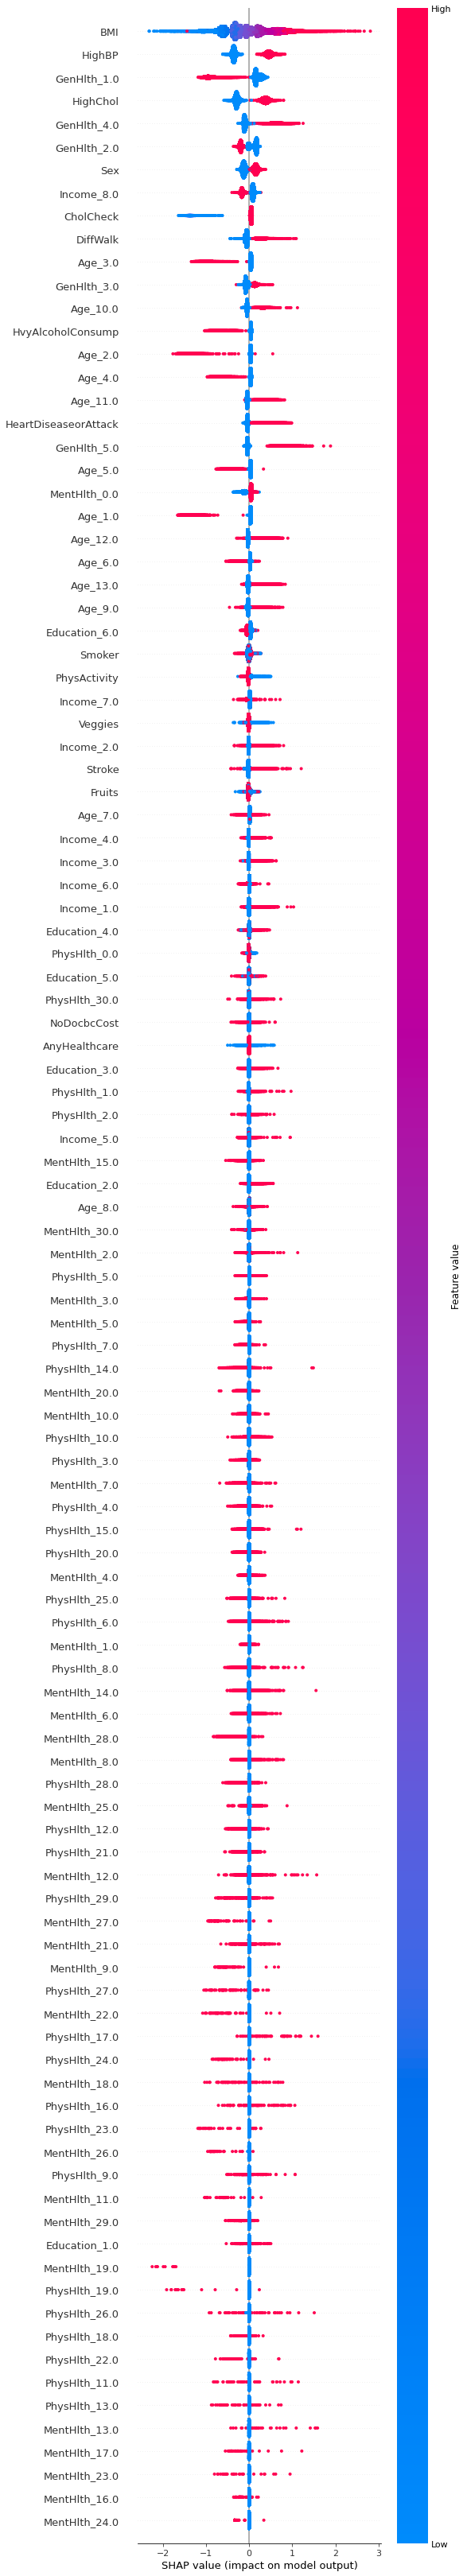

In [ ]:
# Поработать : 
# GenHlth - разбить на две категории (1,2) и остальные
# Age - то же самое (1-5) и остальные
# Income - (8) и остальные 
# Education - 6 и остальные
# PhysHlth, MentHlth, - разбить на три категории и посмотреть что выйдет
shap.summary_plot(shap_values, X_train, max_display=X_train.shape[1])

In [ ]:
# метрики не улучшаются
preds = model.predict(X_test)
proba = model.predict_proba(X_test)[:, 1]
metrics(y_test, preds, show=True)
create_metrics(y_test, proba, show=True)

Precision=0.557, Recall=0.166, F_score=0.256, Accuracy=0.866509
Accuracy=0.807, Precision=0.379, Recall=0.622, F-score=0.471, Best_threshold=0.229114


invalid value encountered in true_divide


In [ ]:
# преобразуем признаки и посмотрим снова
# используем копию датафрейма
df_2 = df.copy()
df_2.GenHlth = np.where((df_2.GenHlth == 1) | (df_2.GenHlth == 2), 0, 1)

df_2.Age = np.where(df_2.Age <= 7, 0, 1)
df_2.Income = np.where(df_2.Income >= 6, 1, 0)
df_2.Education = np.where(df_2.Education >= 5, 1, 0)


df_2.loc[df_2.PhysHlth <= 10, 'PhysHlth'] = 0
df_2.loc[(df_2.PhysHlth > 10) & (df_2.PhysHlth <= 20), 'PhysHlth'] = 1
df_2.loc[df_2.PhysHlth > 20, 'PhysHlth'] = 2

df_2.loc[df_2.MentHlth <= 10, 'MentHlth'] = 0
df_2.loc[(df_2.MentHlth > 10) & (df_2.MentHlth <= 20), 'MentHlth'] = 1
df_2.loc[df_2.MentHlth > 20, 'MentHlth'] = 2

In [ ]:
X = df_2.drop('Diabetes_binary', axis=1)
y = df_2.Diabetes_binary

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.25,
                                                   random_state=42)

In [ ]:
model = CatBoostClassifier(silent=True)
model.fit(X_train, y_train)
preds = model.predict(X_test)
proba = model.predict_proba(X_test)[:, 1]
metrics(y_test, preds, show=True)
create_metrics(y_test, proba, show=True)

Precision=0.545, Recall=0.139, F_score=0.221, Accuracy=0.864980
Accuracy=0.791, Precision=0.359, Recall=0.648, F-score=0.462, Best_threshold=0.215159


In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

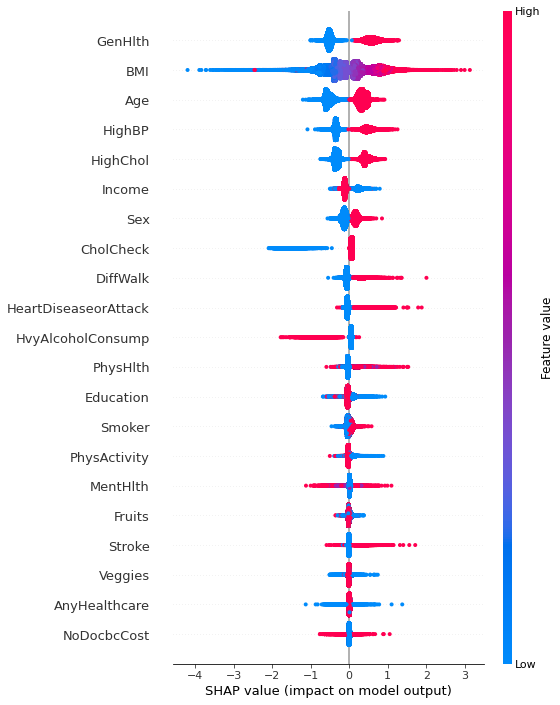

In [ ]:
# есть смысл выкинуть menthlth, Nodoccost, anyhealthcare
shap.summary_plot(shap_values, X_train, max_display=X_train.shape[1])

In [ ]:
# запустим случайный лес
model = RandomForestClassifier()
model.fit(X_train, y_train)
importance = model.feature_importances_

In [ ]:
# в случайном лесу уже чуть по другому, но основные признаки в топе нашлись
feature_names = [i for i in X_train.columns]
forest_importances = pd.DataFrame(importance, index=feature_names, columns=['importance'])
forest_importances.sort_values(by=['importance'], ascending=False)

,importance
BMI,0.341765
HighBP,0.059077
GenHlth,0.050635
Fruits,0.046024
PhysHlth,0.044821
Smoker,0.044281
Education,0.038601
Veggies,0.038161
Sex,0.037950
MentHlth,0.037854


In [ ]:
# метрики тоже особо не радуют
preds = model.predict(X_test)
proba = model.predict_proba(X_test)[:, 1]
metrics(y_test, preds, show=True)
create_metrics(y_test, proba, show=True)

Precision=0.388, Recall=0.210, F_score=0.272, Accuracy=0.845080
Accuracy=0.748, Precision=0.299, Recall=0.611, F-score=0.401, Best_threshold=0.179218


## Data preprocessing

In [ ]:
# класс для преобразования данных, который можно запихнуть в пайплайн
class DataTransformer(BaseEstimator, TransformerMixin):

  def fit(self, X, y=None):
    return self

  def transform(self, X): 
    X.drop(['AnyHealthcare', 'NoDocbcCost','Stroke', 'Veggies', 'Fruits'], axis=1, inplace=True)
    X.GenHlth = np.where(X.GenHlth <= 2, 0, 1)
    X.Age = np.where(X.Age <= 7, 0, 1)
    X.Income = np.where(X.Income >= 6, 1, 0)
    X.Education = np.where(X.Education >= 5, 1, 0)
    X.loc[X.PhysHlth <= 10, 'PhysHlth'] = 0
    X.loc[X.PhysHlth > 10, 'PhysHlth'] = 1
    return X


In [ ]:
X = df.drop('Diabetes_binary', axis=1)
y = df.Diabetes_binary
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.25,
                                                  random_state=42)

pipeline = Pipeline([('data_preprocessing', DataTransformer()),
                     ('Classifier', CatBoostClassifier(silent=True,  
                                                                                                      
                                                  ))])
pipeline.fit(X_train, y_train)
preds = pipeline.predict_proba(X_test)[:, 1]
create_metrics(y_test, preds, show=True)

Accuracy=0.796, Precision=0.364, Recall=0.631, F-score=0.461, Best_threshold=0.222389


In [10]:
# метрики стоят на месте, перепишем класс предобработки
class DataTransformer_2(BaseEstimator, TransformerMixin):

  def fit(self, X, y=None):
    return self

  def transform(self, X): 
    X.drop(['AnyHealthcare', 'NoDocbcCost','Stroke', 'Veggies', 'Fruits'], axis=1, inplace=True)
    X.loc[X.BMI > 60, "BMI"] = X.BMI.median()
    X.loc[X.PhysHlth > 29, 'PhysHlth'] = X.PhysHlth.median()
    X.loc[X.MentHlth > 29, 'MentHlth'] = X.MentHlth.median()
    return X

In [ ]:
X = df.drop('Diabetes_binary', axis=1)
y = df.Diabetes_binary

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.25,
                                                   random_state=42)
cat = Pipeline([('preprocessing',DataTransformer_2()),
              ('classifier',CatBoostClassifier(silent=True,                                                     
                                                       ))])
cat.fit(X_train, y_train)
preds = cat.predict_proba(X_test)[:, 1]
create_metrics(y_test, preds, show=True)

Accuracy=0.794, Precision=0.364, Recall=0.655, F-score=0.468, Best_threshold=0.214370


In [ ]:
# Прогресс есть, но небольшой. сохраним модель и попробуем побороться с разбалансированностью данных
with open('/content/drive/MyDrive/business_ml/course_project/cat3.dill', 'wb') as f:
  dill.dump(cat, f)

In [ ]:
X = df.drop('Diabetes_binary', axis=1)
y = df.Diabetes_binary
resampler = SMOTEENN(sampling_strategy = 'all',random_state = 123)


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                      test_size=0.25,
                                                    random_state=42)
Ox_train, oy_train = resampler.fit_resample(X_train, y_train)
f = '/content/drive/MyDrive/business_ml/course_project'
Ox_train.to_csv(f + 'X_train_over.csv', index=False, columns=list(X_train.columns))
X_test.to_csv(f + 'X_test_over.csv', index=False, columns=list(X_test.columns))
oy_train.to_csv(f + 'y_train_over.csv', index=False)
y_test.to_csv(f + 'y_test_over.csv', index=False)

In [ ]:
cat = Pipeline([('preprocessing',DataTransformer()),
                  ('classifier',CatBoostClassifier(silent=True                                                 
                                                          ))])
cat.fit(Ox_train, oy_train)
preds = cat.predict_proba(X_test)[:, 1]
create_metrics(y_test, preds, show=True)  

Accuracy=0.798, Precision=0.364, Recall=0.620, F-score=0.459, Best_threshold=0.584785


In [ ]:
# попробуем нейронные сети
class DataTransformer_3():
  def transform_data(self, X): 
    X.drop(['AnyHealthcare', 'NoDocbcCost','Stroke', 'Veggies', 'Fruits'], axis=1, inplace=True)
    X.loc[X.BMI > 60, "BMI"] = X.BMI.median()
    X.loc[X.PhysHlth > 29, 'PhysHlth'] = X.PhysHlth.median()
    X.loc[X.MentHlth > 29, 'MentHlth'] = X.MentHlth.median()
    return X

transformer = DataTransformer_3()
df_3 = df.copy()
df_3 = transformer.transform_data(df_3)
X = df_3.drop('Diabetes_binary', axis=1)
y = df_3.Diabetes_binary

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.25,
                                                   random_state=42)        

nw = tf.keras.models.Sequential([
    keras.layers.Dense(X_train.shape[1]),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')                   
                                     
])
nw.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy', 'Recall', 'Precision'])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

nw.fit(X_train, y_train, epochs=30, batch_size=150, validation_data=(X_test, y_test))

Epoch 1/30
1269/1269 [==============================] - 65s 5ms/step - loss: 0.3474 - accuracy: 0.8595 - recall: 0.1061 - precision: 0.4864 - val_loss: 0.3225 - val_accuracy: 0.8631 - val_recall: 0.1672 - val_precision: 0.5144
Epoch 2/30
1269/1269 [==============================] - 6s 4ms/step - loss: 0.3272 - accuracy: 0.8629 - recall: 0.1159 - precision: 0.5437 - val_loss: 0.3183 - val_accuracy: 0.8659 - val_recall: 0.1125 - val_precision: 0.5749
Epoch 3/30
1269/1269 [==============================] - 6s 5ms/step - loss: 0.3242 - accuracy: 0.8635 - recall: 0.1235 - precision: 0.5521 - val_loss: 0.3175 - val_accuracy: 0.8654 - val_recall: 0.0710 - val_precision: 0.6122
Epoch 4/30
1269/1269 [==============================] - 6s 4ms/step - loss: 0.3214 - accuracy: 0.8640 - recall: 0.1262 - precision: 0.5592 - val_loss: 0.3141 - val_accuracy: 0.8672 - val_recall: 0.1497 - val_precision: 0.5747
Epoch 5/30
1269/1269 [==============================] - 6s 4ms/step - loss: 0.3194 - accuracy: 

In [ ]:
nw.evaluate(X_test, y_test, batch_size=150)

423/423 [==============================] - 1s 3ms/step - loss: 0.3105 - accuracy: 0.8673 - recall: 0.1291 - precision: 0.5912


[0.31054848432540894,
 0.867328941822052,
 0.1290653944015503,
 0.5912179946899414]

In [ ]:
preds = nw.predict(X_test)
create_metrics(y_test, preds, show=True)

1982/1982 [==============================] - 3s 1ms/step
Accuracy=0.808, Precision=0.379, Recall=0.611, F-score=0.468, Best_threshold=0.224740


In [11]:
# Возьмем данные с SMOOTEEN, сгенерированные выше и попытаемся снова
X_train = pd.read_csv('/content/drive/MyDrive/business_ml/course_projectX_train_over.csv')
y_train = pd.read_csv('/content/drive/MyDrive/business_ml/course_projecty_train_over.csv')
X_test = pd.read_csv('/content/drive/MyDrive/business_ml/course_projectX_test_over.csv')
y_test = pd.read_csv('/content/drive/MyDrive/business_ml/course_projecty_test_over.csv')

In [12]:
# создадим pipeline
# в плане recall результат гораздо лучше, но остальные метрики проседают, особенно precision
# в принципе конкретно для этой задачи это вполне преемлемо
nw = tf.keras.models.Sequential([
    keras.layers.Dense(X_train.shape[1]),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')                   
                                     
])
nw.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy', 'Recall', 'Precision'])
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

pipeline = Pipeline([
    ('preprocessing', DataTransformer_2()),
    ('nw',nw)
])

pipeline.fit(X_train, y_train, nw__epochs=50, nw__batch_size=150, nw__callbacks=callback)

Epoch 1/50
1689/1689 [==============================] - 9s 4ms/step - loss: 0.3449 - accuracy: 0.8486 - recall: 0.9076 - precision: 0.8552
Epoch 2/50
1689/1689 [==============================] - 9s 5ms/step - loss: 0.3188 - accuracy: 0.8629 - recall: 0.9115 - precision: 0.8715
Epoch 3/50
1689/1689 [==============================] - 12s 7ms/step - loss: 0.3116 - accuracy: 0.8665 - recall: 0.9116 - precision: 0.8764
Epoch 4/50
1689/1689 [==============================] - 12s 7ms/step - loss: 0.3092 - accuracy: 0.8676 - recall: 0.9114 - precision: 0.8780
Epoch 5/50
1689/1689 [==============================] - 8s 5ms/step - loss: 0.3053 - accuracy: 0.8699 - recall: 0.9119 - precision: 0.8809
Epoch 6/50
1689/1689 [==============================] - 9s 5ms/step - loss: 0.2968 - accuracy: 0.8740 - recall: 0.9128 - precision: 0.8858
Epoch 7/50
1689/1689 [==============================] - 9s 6ms/step - loss: 0.2877 - accuracy: 0.8781 - recall: 0.9130 - precision: 0.8915
Epoch 8/50
1689/1689 [===

Pipeline(steps=[('preprocessing', DataTransformer_2()),
                ('nw',
                 <keras.engine.sequential.Sequential object at 0x7f783571ba60>)])

In [13]:
eval_data = pipeline['preprocessing'].transform(X_test)

In [14]:
pipeline['nw'].evaluate(eval_data, y_test)

1982/1982 [==============================] - 8s 4ms/step - loss: 0.8185 - accuracy: 0.6762 - recall: 0.8466 - precision: 0.2788


[0.8184757828712463,
 0.6761747002601624,
 0.8466278910636902,
 0.27878400683403015]

In [ ]:
# loss: loss: 0.8185 - accuracy: 0.6762 - recall: 0.8466 - precision: 0.2788

In [16]:
pipeline['nw'].save('/content/drive/MyDrive/business_ml/course_project/nw_model')

In [ ]:
!pip freeze > /content/drive/MyDrive/business_ml/course_project/requirements.txt